In [97]:
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss

In [130]:
df = pd.read_csv("./data/GenshinReviews1.csv")

In [131]:
df.head()

,score,content
0,1,whatever reason game used work fine except cu...
1,1,like game seriously need fix mostly either ab...
2,1,downloaded worked downloaded say insufficient...
3,1,data mbps open game ms speed normal daily run...
4,1,play game problems game downloading try play ...


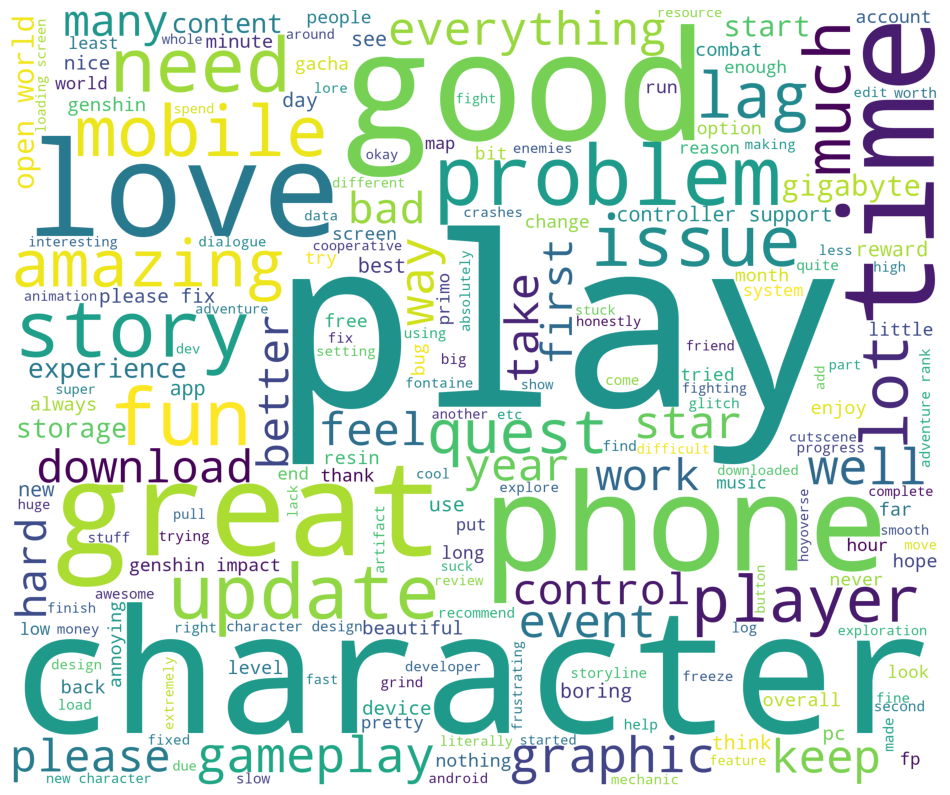

In [132]:
corpus_cloud = ' '.join(df['content'])
STOPWORDS.update(['PRON','game','games','let','able', 'say'])
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=2400,height=2000).generate(corpus_cloud)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')

# plt.savefig("wordcloud.jpg")
plt.show()

In [134]:
# CREATE DICTIONARY TO COUNT THE WORDS
count_dict_alex = {}

for doc in df['content']:
    for word in doc.split():
        if word in count_dict_alex.keys():
            count_dict_alex[word] +=1
        else:
            count_dict_alex[word] = 1
            
for key, value in sorted(count_dict_alex.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

sorted_dict = sorted(count_dict_alex.items(), key=lambda item: item[1])

# Specify the file name to write the output
output_file_path = 'word_count_output.txt'

# Open the file in write mode ('w') and write the content
with open(output_file_path, 'w') as output_file:
    for key, value in sorted_dict:
        output_file.write(f"{key}: {value}\n")

promptly: 1
warn: 1
infuscent: 1
powercrept: 1
serve: 1
smallest: 1
lonely: 1
popped: 1
destination: 1
anybody: 1
twig: 1
nothin: 1
dust: 1
sigh: 1
employee: 1
terabyte: 1
folks: 1
freezer: 1
charcters: 1
wang: 1
dun: 1
bui: 1
zui: 1
overshadows: 1
aggravatingly: 1
gearing: 1
sliders: 1
exprience: 1
carsh: 1
eyesore: 1
bull: 1
faulty: 1
subsequent: 1
alternatives: 1
individuals: 1
asf: 1
everyime: 1
lazyness: 1
ineptitude: 1
joycons: 1
fckng: 1
fulfilled: 1
scraps: 1
shitty: 1
skillset: 1
keymapper: 1
temp: 1
aftertaste: 1
titanic: 1
brick: 1
massage: 1
walked: 1
shadows: 1
fastest: 1
favouritism: 1
slang: 1
overlooked: 1
eartened: 1
daunting: 1
skirks: 1
lame: 1
suggestive: 1
anticipation: 1
fabric: 1
tech: 1
publicly: 1
ueed: 1
addinga: 1
overit: 1
training: 1
incapable: 1
wested: 1
listing: 1
citizen: 1
blood: 1
tears: 1
rigth: 1
benefitting: 1
seelie: 1
gifting: 1
contest: 1
winners: 1
lev: 1
sapping: 1
tokens: 1
progess: 1
backgorund: 1
silently: 1
seahorse: 1
mentality: 1
keybind

UnicodeEncodeError: 'charmap' codec can't encode character '\u0142' in position 3: character maps to <undefined>

In [135]:
# REMOVE WORDS THAT OCCUR LESS THAN 10 TIMES
low_value = 10
bad_words = [key for key in count_dict_alex.keys() if count_dict_alex[key] < low_value]

In [136]:
# CREATE A LIST OF LISTS - EACH DOCUMENT IS A STRING BROKEN INTO A LIST OF WORDS
corpus = [doc.split() for doc in df['content']]
clean_list = []
for document in corpus:
    clean_list.append([word for word in document if word not in bad_words])

In [137]:
clean_list

[['whatever',
  'reason',
  'game',
  'used',
  'work',
  'fine',
  'except',
  'cutscenes',
  'crashed',
  'play',
  'use',
  'open',
  'shows',
  'black',
  'screen',
  'crashes',
  'tried',
  'uninstalling',
  'reinstalling',
  'took',
  'hour',
  'way',
  'restarting',
  'device',
  'work',
  'fun',
  'game'],
 ['like',
  'game',
  'seriously',
  'need',
  'fix',
  'mostly',
  'either',
  'able',
  'skip',
  'dialogue',
  'stuff',
  'archon',
  'quest',
  'current',
  'update',
  'minute',
  'able',
  'stop',
  'need',
  'everything',
  'least',
  'people',
  'long',
  'stop',
  'course',
  'need',
  'fix',
  'everyone',
  'wants',
  'time',
  'everything',
  'straight',
  'away'],
 ['downloaded',
  'worked',
  'downloaded',
  'say',
  'insufficient',
  'space',
  'every',
  'single',
  'time',
  'plenty',
  'space',
  'deleted',
  'apps',
  'removed',
  'pictures',
  'everything',
  'try',
  'work',
  'delete',
  'redownload',
  'restart',
  'phone',
  'clear',
  'cache',
  'data'

In [138]:
# USE CLEAN_LIST TO CREATE CORPUS
corpus=[]
for item in clean_list:
    item = ' '.join(item)
    corpus.append(item)
    
corpus

['whatever reason game used work fine except cutscenes crashed play use open shows black screen crashes tried uninstalling reinstalling took hour way restarting device work fun game',
 'like game seriously need fix mostly either able skip dialogue stuff archon quest current update minute able stop need everything least people long stop course need fix everyone wants time everything straight away',
 'downloaded worked downloaded say insufficient space every single time plenty space deleted apps removed pictures everything try work delete redownload restart phone clear cache data clear cache data playstore everything disappointing hell cannot play',
 'data open game ms speed normal daily run mission ping turns ms every time meet enemy like must happen fighting ms normal meet enemy ms lag time waste lot money feel like like happens sorry english bad play game since released disappointing',
 'play game problems game downloading try play say space stops starts loading never finish process p

In [139]:
import gensim
from gensim import corpora
from gensim.models import LdaModel, LdaMulticore
import gensim.downloader as api
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

In [140]:
clean_list[0][:15]

['whatever',
 'reason',
 'game',
 'used',
 'work',
 'fine',
 'except',
 'cutscenes',
 'crashed',
 'play',
 'use',
 'open',
 'shows',
 'black',
 'screen']

In [141]:
# CREATE THE INPUTS OF LDA MODEL: DICTIONARY AND CORPUS
corpora_dict = corpora.Dictionary(clean_list)
corpus = [corpora_dict.doc2bow(line) for line in clean_list]

In [142]:
# TRAIN THE LDA MODEL
lda_model = LdaModel(corpus=corpus,
                         id2word=corpora_dict,
                         random_state=100,
                         num_topics=3,
                         passes=5,
                         per_word_topics=True)

# See the topics
lda_model.print_topics(-1)

[(0,
  '0.081*"game" + 0.030*"play" + 0.017*"phone" + 0.014*"graphic" + 0.012*"mobile" + 0.012*"like" + 0.011*"good" + 0.010*"amazing" + 0.010*"pc" + 0.009*"cannot"'),
 (1,
  '0.046*"game" + 0.019*"play" + 0.015*"controller" + 0.013*"like" + 0.012*"star" + 0.012*"character" + 0.011*"love" + 0.011*"support" + 0.011*"please" + 0.010*"controls"'),
 (2,
  '0.067*"game" + 0.023*"character" + 0.022*"play" + 0.015*"graphic" + 0.015*"story" + 0.014*"great" + 0.011*"like" + 0.011*"good" + 0.011*"world" + 0.009*"gameplay"')]

In [143]:
from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count
import gensim.downloader as api

In [144]:
# # Train Word2Vec model. Defaults result vector size = 100
# model = Word2Vec(clean_list, min_count = 0, workers=cpu_count())

# # Get the word vector for given word
# model['love']

# model.most_similar('love')


# Train Word2Vec model. Defaults result vector size = 100
model = Word2Vec(clean_list, min_count=0, workers=cpu_count())

# Get the word vector for a given word
vector = model.wv['love']

# Find words most similar to 'love'
similar_words = model.wv.most_similar('love')

print("Vector", vector)
print("Words similar to:", similar_words)


Vector [-0.12561342  0.49774694  0.26156545  0.08566576  0.09231972 -0.51692444
  0.17066623  0.74231577 -0.4482277  -0.1896134  -0.27771991 -0.44348183
 -0.1154753  -0.03198727 -0.08994394 -0.2095795   0.17129233 -0.09918864
 -0.16654977 -0.852105    0.06000829  0.15062323  0.336225   -0.1627499
 -0.34227055  0.16151781 -0.2648576  -0.24888448 -0.34452474  0.25918183
  0.4246507  -0.01380429  0.2667673  -0.42487764 -0.24004832  0.37006792
  0.13717818 -0.18543932 -0.12856083 -0.6787979   0.08591799 -0.17805016
 -0.09175296 -0.06132825  0.19673528 -0.25184423 -0.2763936  -0.18719321
  0.38356486  0.20755431  0.16411218 -0.527188   -0.10904561  0.00485311
 -0.22104993  0.20741718  0.21627194 -0.2655791  -0.48139766 -0.11824537
 -0.00679274  0.15092073 -0.04304612 -0.13276075 -0.15228324  0.406461
  0.26422304  0.34134153 -0.45753226  0.39707693 -0.25135702  0.28566542
  0.5142515  -0.01571523  0.26425722  0.29378873  0.10159963 -0.06969447
 -0.17951125  0.08083233 -0.11048458 -0.0239131

In [145]:
dct = corpora.Dictionary(clean_list)
corpus = [dct.doc2bow(line) for line in clean_list]

# Build the bigram models
bigram = gensim.models.phrases.Phrases(clean_list, min_count=3, threshold=10)

# Construct bigram
print(bigram[clean_list[1]])

['like', 'game', 'seriously', 'need', 'fix', 'mostly', 'either', 'able', 'skip_dialogue', 'stuff', 'archon_quest', 'current', 'update', 'minute', 'able', 'stop', 'need', 'everything', 'least', 'people', 'long', 'stop', 'course', 'need', 'fix', 'everyone', 'wants', 'time', 'everything', 'straight', 'away']


In [146]:
analyser = SentimentIntensityAnalyzer()

In [147]:
def sentimentScore(sentences):
    analyzer = SentimentIntensityAnalyzer()
    results = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        print(str(vs))
        results.append(vs) 
    return results

In [148]:
sentiment = sentimentScore(df['content'])


{'neg': 0.0, 'neu': 0.789, 'pos': 0.211, 'compound': 0.7579}
{'neg': 0.143, 'neu': 0.724, 'pos': 0.133, 'compound': -0.1037}
{'neg': 0.223, 'neu': 0.659, 'pos': 0.118, 'compound': -0.6844}
{'neg': 0.374, 'neu': 0.478, 'pos': 0.148, 'compound': -0.9337}
{'neg': 0.26, 'neu': 0.54, 'pos': 0.199, 'compound': -0.1184}
{'neg': 0.204, 'neu': 0.404, 'pos': 0.393, 'compound': 0.854}
{'neg': 0.149, 'neu': 0.7, 'pos': 0.151, 'compound': 0.0258}
{'neg': 0.0, 'neu': 0.71, 'pos': 0.29, 'compound': 0.7906}
{'neg': 0.152, 'neu': 0.659, 'pos': 0.189, 'compound': 0.1346}
{'neg': 0.175, 'neu': 0.457, 'pos': 0.368, 'compound': 0.8658}
{'neg': 0.074, 'neu': 0.597, 'pos': 0.33, 'compound': 0.8402}
{'neg': 0.239, 'neu': 0.737, 'pos': 0.024, 'compound': -0.8957}
{'neg': 0.187, 'neu': 0.659, 'pos': 0.154, 'compound': -0.4939}
{'neg': 0.148, 'neu': 0.71, 'pos': 0.142, 'compound': -0.0516}
{'neg': 0.252, 'neu': 0.668, 'pos': 0.08, 'compound': -0.6293}
{'neg': 0.069, 'neu': 0.741, 'pos': 0.19, 'compound': 0.5574}

{'neg': 0.166, 'neu': 0.524, 'pos': 0.31, 'compound': 0.8519}
{'neg': 0.302, 'neu': 0.428, 'pos': 0.27, 'compound': 0.2332}
{'neg': 0.208, 'neu': 0.53, 'pos': 0.263, 'compound': 0.128}
{'neg': 0.273, 'neu': 0.561, 'pos': 0.166, 'compound': -0.4588}
{'neg': 0.142, 'neu': 0.405, 'pos': 0.454, 'compound': 0.8689}
{'neg': 0.0, 'neu': 0.367, 'pos': 0.633, 'compound': 0.979}
{'neg': 0.264, 'neu': 0.491, 'pos': 0.245, 'compound': -0.1065}
{'neg': 0.049, 'neu': 0.765, 'pos': 0.185, 'compound': 0.6705}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.11, 'neu': 0.681, 'pos': 0.209, 'compound': 0.6378}
{'neg': 0.055, 'neu': 0.528, 'pos': 0.417, 'compound': 0.9246}
{'neg': 0.105, 'neu': 0.7, 'pos': 0.195, 'compound': 0.3182}
{'neg': 0.33, 'neu': 0.423, 'pos': 0.246, 'compound': -0.5496}
{'neg': 0.202, 'neu': 0.554, 'pos': 0.244, 'compound': 0.1027}
{'neg': 0.129, 'neu': 0.731, 'pos': 0.14, 'compound': 0.0936}
{'neg': 0.193, 'neu': 0.484, 'pos': 0.323, 'compound': 0.7778}
{'neg': 0.

{'neg': 0.237, 'neu': 0.763, 'pos': 0.0, 'compound': -0.4767}
{'neg': 0.188, 'neu': 0.667, 'pos': 0.145, 'compound': -0.1779}
{'neg': 0.282, 'neu': 0.29, 'pos': 0.427, 'compound': 0.7579}
{'neg': 0.265, 'neu': 0.735, 'pos': 0.0, 'compound': -0.6597}
{'neg': 0.0, 'neu': 0.675, 'pos': 0.325, 'compound': 0.7717}
{'neg': 0.397, 'neu': 0.337, 'pos': 0.266, 'compound': -0.8555}
{'neg': 0.187, 'neu': 0.54, 'pos': 0.273, 'compound': 0.34}
{'neg': 0.306, 'neu': 0.484, 'pos': 0.211, 'compound': -0.5165}
{'neg': 0.24, 'neu': 0.419, 'pos': 0.341, 'compound': 0.34}
{'neg': 0.0, 'neu': 0.438, 'pos': 0.562, 'compound': 0.9403}
{'neg': 0.2, 'neu': 0.367, 'pos': 0.433, 'compound': 0.7184}
{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.4019}
{'neg': 0.271, 'neu': 0.591, 'pos': 0.138, 'compound': -0.4019}
{'neg': 0.234, 'neu': 0.601, 'pos': 0.165, 'compound': -0.0936}
{'neg': 0.117, 'neu': 0.463, 'pos': 0.421, 'compound': 0.9153}
{'neg': 0.118, 'neu': 0.718, 'pos': 0.164, 'compound': 0.2263}
{'ne

{'neg': 0.208, 'neu': 0.55, 'pos': 0.242, 'compound': 0.2486}
{'neg': 0.317, 'neu': 0.464, 'pos': 0.219, 'compound': -0.5574}
{'neg': 0.201, 'neu': 0.459, 'pos': 0.34, 'compound': 0.5496}
{'neg': 0.128, 'neu': 0.478, 'pos': 0.394, 'compound': 0.9531}
{'neg': 0.19, 'neu': 0.641, 'pos': 0.168, 'compound': -0.0516}
{'neg': 0.15, 'neu': 0.558, 'pos': 0.292, 'compound': 0.3197}
{'neg': 0.389, 'neu': 0.507, 'pos': 0.104, 'compound': -0.8442}
{'neg': 0.29, 'neu': 0.534, 'pos': 0.175, 'compound': -0.5434}
{'neg': 0.341, 'neu': 0.613, 'pos': 0.046, 'compound': -0.8268}
{'neg': 0.208, 'neu': 0.506, 'pos': 0.286, 'compound': 0.6237}
{'neg': 0.323, 'neu': 0.396, 'pos': 0.28, 'compound': -0.5859}
{'neg': 0.209, 'neu': 0.551, 'pos': 0.24, 'compound': 0.2399}
{'neg': 0.128, 'neu': 0.552, 'pos': 0.321, 'compound': 0.9041}
{'neg': 0.229, 'neu': 0.587, 'pos': 0.184, 'compound': -0.1761}
{'neg': 0.125, 'neu': 0.478, 'pos': 0.397, 'compound': 0.93}
{'neg': 0.088, 'neu': 0.684, 'pos': 0.228, 'compound': 0.

{'neg': 0.143, 'neu': 0.37, 'pos': 0.487, 'compound': 0.9612}
{'neg': 0.0, 'neu': 0.684, 'pos': 0.316, 'compound': 0.8883}
{'neg': 0.151, 'neu': 0.635, 'pos': 0.214, 'compound': 0.5267}
{'neg': 0.035, 'neu': 0.697, 'pos': 0.268, 'compound': 0.9136}
{'neg': 0.256, 'neu': 0.676, 'pos': 0.068, 'compound': -0.8833}
{'neg': 0.126, 'neu': 0.471, 'pos': 0.403, 'compound': 0.9545}
{'neg': 0.083, 'neu': 0.494, 'pos': 0.422, 'compound': 0.9776}
{'neg': 0.177, 'neu': 0.455, 'pos': 0.368, 'compound': 0.9689}
{'neg': 0.147, 'neu': 0.517, 'pos': 0.336, 'compound': 0.9136}
{'neg': 0.046, 'neu': 0.656, 'pos': 0.298, 'compound': 0.8797}
{'neg': 0.133, 'neu': 0.58, 'pos': 0.288, 'compound': 0.9287}
{'neg': 0.105, 'neu': 0.66, 'pos': 0.235, 'compound': 0.6764}
{'neg': 0.218, 'neu': 0.538, 'pos': 0.244, 'compound': 0.3818}
{'neg': 0.248, 'neu': 0.559, 'pos': 0.193, 'compound': -0.2384}
{'neg': 0.159, 'neu': 0.634, 'pos': 0.207, 'compound': 0.0402}
{'neg': 0.157, 'neu': 0.426, 'pos': 0.417, 'compound': 0.9

{'neg': 0.0, 'neu': 0.636, 'pos': 0.364, 'compound': 0.8225}
{'neg': 0.128, 'neu': 0.588, 'pos': 0.285, 'compound': 0.8428}
{'neg': 0.068, 'neu': 0.578, 'pos': 0.354, 'compound': 0.8126}
{'neg': 0.067, 'neu': 0.404, 'pos': 0.528, 'compound': 0.9524}
{'neg': 0.23, 'neu': 0.426, 'pos': 0.344, 'compound': 0.7727}
{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.4404}
{'neg': 0.167, 'neu': 0.483, 'pos': 0.35, 'compound': 0.7884}
{'neg': 0.053, 'neu': 0.755, 'pos': 0.193, 'compound': 0.6558}
{'neg': 0.096, 'neu': 0.638, 'pos': 0.266, 'compound': 0.5859}
{'neg': 0.07, 'neu': 0.388, 'pos': 0.543, 'compound': 0.946}
{'neg': 0.051, 'neu': 0.637, 'pos': 0.312, 'compound': 0.9136}
{'neg': 0.119, 'neu': 0.759, 'pos': 0.123, 'compound': 0.2796}
{'neg': 0.259, 'neu': 0.416, 'pos': 0.325, 'compound': 0.5719}
{'neg': 0.116, 'neu': 0.5, 'pos': 0.384, 'compound': 0.8957}
{'neg': 0.175, 'neu': 0.583, 'pos': 0.242, 'compound': 0.6124}
{'neg': 0.13, 'neu': 0.412, 'pos': 0.458, 'compound': 0.9577}
{'n

{'neg': 0.155, 'neu': 0.511, 'pos': 0.335, 'compound': 0.9186}
{'neg': 0.201, 'neu': 0.495, 'pos': 0.304, 'compound': 0.8976}
{'neg': 0.0, 'neu': 0.396, 'pos': 0.604, 'compound': 0.9826}
{'neg': 0.236, 'neu': 0.543, 'pos': 0.222, 'compound': 0.1043}
{'neg': 0.089, 'neu': 0.664, 'pos': 0.247, 'compound': 0.8526}
{'neg': 0.0, 'neu': 0.699, 'pos': 0.301, 'compound': 0.8809}
{'neg': 0.079, 'neu': 0.466, 'pos': 0.455, 'compound': 0.9485}
{'neg': 0.064, 'neu': 0.515, 'pos': 0.421, 'compound': 0.9607}
{'neg': 0.178, 'neu': 0.442, 'pos': 0.38, 'compound': 0.9451}
{'neg': 0.162, 'neu': 0.61, 'pos': 0.229, 'compound': 0.4902}
{'neg': 0.1, 'neu': 0.498, 'pos': 0.402, 'compound': 0.9517}
{'neg': 0.12, 'neu': 0.702, 'pos': 0.179, 'compound': 0.743}
{'neg': 0.257, 'neu': 0.496, 'pos': 0.247, 'compound': -0.3447}
{'neg': 0.25, 'neu': 0.343, 'pos': 0.407, 'compound': 0.8591}
{'neg': 0.1, 'neu': 0.468, 'pos': 0.432, 'compound': 0.939}
{'neg': 0.247, 'neu': 0.43, 'pos': 0.323, 'compound': 0.7501}
{'neg'

{'neg': 0.077, 'neu': 0.559, 'pos': 0.364, 'compound': 0.9515}
{'neg': 0.03, 'neu': 0.723, 'pos': 0.247, 'compound': 0.8818}
{'neg': 0.042, 'neu': 0.502, 'pos': 0.456, 'compound': 0.9674}
{'neg': 0.074, 'neu': 0.681, 'pos': 0.245, 'compound': 0.743}
{'neg': 0.049, 'neu': 0.594, 'pos': 0.358, 'compound': 0.9451}
{'neg': 0.0, 'neu': 0.509, 'pos': 0.491, 'compound': 0.975}
{'neg': 0.151, 'neu': 0.687, 'pos': 0.162, 'compound': 0.1531}
{'neg': 0.025, 'neu': 0.691, 'pos': 0.284, 'compound': 0.9451}
{'neg': 0.116, 'neu': 0.537, 'pos': 0.347, 'compound': 0.8876}
{'neg': 0.081, 'neu': 0.524, 'pos': 0.395, 'compound': 0.9618}
{'neg': 0.242, 'neu': 0.574, 'pos': 0.185, 'compound': -0.4173}
{'neg': 0.039, 'neu': 0.501, 'pos': 0.46, 'compound': 0.9661}
{'neg': 0.279, 'neu': 0.508, 'pos': 0.212, 'compound': -0.4019}
{'neg': 0.2, 'neu': 0.525, 'pos': 0.275, 'compound': 0.6096}
{'neg': 0.106, 'neu': 0.519, 'pos': 0.376, 'compound': 0.9442}
{'neg': 0.086, 'neu': 0.596, 'pos': 0.318, 'compound': 0.91}


{'neg': 0.087, 'neu': 0.443, 'pos': 0.469, 'compound': 0.9798}
{'neg': 0.078, 'neu': 0.608, 'pos': 0.314, 'compound': 0.8288}
{'neg': 0.05, 'neu': 0.43, 'pos': 0.52, 'compound': 0.9628}
{'neg': 0.261, 'neu': 0.645, 'pos': 0.094, 'compound': -0.6369}
{'neg': 0.173, 'neu': 0.471, 'pos': 0.356, 'compound': 0.8012}
{'neg': 0.078, 'neu': 0.494, 'pos': 0.427, 'compound': 0.9001}
{'neg': 0.342, 'neu': 0.509, 'pos': 0.149, 'compound': -0.9219}
{'neg': 0.182, 'neu': 0.348, 'pos': 0.47, 'compound': 0.9631}
{'neg': 0.188, 'neu': 0.457, 'pos': 0.355, 'compound': 0.8757}
{'neg': 0.175, 'neu': 0.57, 'pos': 0.255, 'compound': 0.6369}
{'neg': 0.038, 'neu': 0.714, 'pos': 0.248, 'compound': 0.8807}
{'neg': 0.162, 'neu': 0.711, 'pos': 0.127, 'compound': -0.1027}
{'neg': 0.219, 'neu': 0.382, 'pos': 0.399, 'compound': 0.8555}
{'neg': 0.102, 'neu': 0.763, 'pos': 0.136, 'compound': 0.2023}
{'neg': 0.264, 'neu': 0.581, 'pos': 0.154, 'compound': -0.6169}
{'neg': 0.356, 'neu': 0.572, 'pos': 0.072, 'compound': -

{'neg': 0.112, 'neu': 0.66, 'pos': 0.228, 'compound': 0.7385}
{'neg': 0.079, 'neu': 0.465, 'pos': 0.456, 'compound': 0.9621}
{'neg': 0.211, 'neu': 0.428, 'pos': 0.361, 'compound': 0.8795}
{'neg': 0.051, 'neu': 0.555, 'pos': 0.394, 'compound': 0.925}
{'neg': 0.105, 'neu': 0.574, 'pos': 0.322, 'compound': 0.8658}
{'neg': 0.07, 'neu': 0.699, 'pos': 0.231, 'compound': 0.7351}
{'neg': 0.024, 'neu': 0.575, 'pos': 0.401, 'compound': 0.9666}
{'neg': 0.071, 'neu': 0.633, 'pos': 0.295, 'compound': 0.9297}
{'neg': 0.145, 'neu': 0.547, 'pos': 0.308, 'compound': 0.8879}
{'neg': 0.117, 'neu': 0.518, 'pos': 0.365, 'compound': 0.875}
{'neg': 0.152, 'neu': 0.525, 'pos': 0.324, 'compound': 0.8701}
{'neg': 0.079, 'neu': 0.593, 'pos': 0.328, 'compound': 0.9337}
{'neg': 0.0, 'neu': 0.672, 'pos': 0.328, 'compound': 0.9337}
{'neg': 0.066, 'neu': 0.638, 'pos': 0.296, 'compound': 0.8316}
{'neg': 0.293, 'neu': 0.495, 'pos': 0.212, 'compound': -0.5585}
{'neg': 0.215, 'neu': 0.472, 'pos': 0.313, 'compound': 0.680

{'neg': 0.097, 'neu': 0.44, 'pos': 0.462, 'compound': 0.9578}
{'neg': 0.083, 'neu': 0.451, 'pos': 0.466, 'compound': 0.9607}
{'neg': 0.062, 'neu': 0.489, 'pos': 0.449, 'compound': 0.9709}
{'neg': 0.25, 'neu': 0.565, 'pos': 0.185, 'compound': -0.4588}
{'neg': 0.08, 'neu': 0.596, 'pos': 0.324, 'compound': 0.9337}
{'neg': 0.08, 'neu': 0.431, 'pos': 0.49, 'compound': 0.9769}
{'neg': 0.06, 'neu': 0.507, 'pos': 0.433, 'compound': 0.9513}
{'neg': 0.054, 'neu': 0.405, 'pos': 0.541, 'compound': 0.9742}
{'neg': 0.037, 'neu': 0.496, 'pos': 0.467, 'compound': 0.9729}
{'neg': 0.077, 'neu': 0.443, 'pos': 0.48, 'compound': 0.9708}
{'neg': 0.071, 'neu': 0.624, 'pos': 0.305, 'compound': 0.8665}
{'neg': 0.194, 'neu': 0.461, 'pos': 0.345, 'compound': 0.8356}
{'neg': 0.179, 'neu': 0.547, 'pos': 0.274, 'compound': 0.6852}
{'neg': 0.13, 'neu': 0.63, 'pos': 0.241, 'compound': 0.7121}
{'neg': 0.055, 'neu': 0.591, 'pos': 0.354, 'compound': 0.9403}
{'neg': 0.165, 'neu': 0.595, 'pos': 0.24, 'compound': 0.5994}
{

{'neg': 0.12, 'neu': 0.546, 'pos': 0.333, 'compound': 0.5994}
{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.9834}
{'neg': 0.074, 'neu': 0.527, 'pos': 0.398, 'compound': 0.87}
{'neg': 0.0, 'neu': 0.358, 'pos': 0.642, 'compound': 0.9729}
{'neg': 0.187, 'neu': 0.415, 'pos': 0.398, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.34, 'pos': 0.66, 'compound': 0.9835}
{'neg': 0.082, 'neu': 0.631, 'pos': 0.287, 'compound': 0.9186}
{'neg': 0.045, 'neu': 0.617, 'pos': 0.338, 'compound': 0.8402}
{'neg': 0.133, 'neu': 0.388, 'pos': 0.48, 'compound': 0.9432}
{'neg': 0.155, 'neu': 0.494, 'pos': 0.352, 'compound': 0.8481}
{'neg': 0.117, 'neu': 0.425, 'pos': 0.458, 'compound': 0.8636}
{'neg': 0.135, 'neu': 0.592, 'pos': 0.273, 'compound': 0.7346}
{'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.9852}
{'neg': 0.0, 'neu': 0.281, 'pos': 0.719, 'compound': 0.9682}
{'neg': 0.0, 'neu': 0.468, 'pos': 0.532, 'compound': 0.9259}
{'neg': 0.0, 'neu': 0.802, 'pos': 0.198, 'compound': 0.5719}
{'neg': 0.0,

{'neg': 0.108, 'neu': 0.685, 'pos': 0.207, 'compound': 0.7003}
{'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'compound': 0.9806}
{'neg': 0.048, 'neu': 0.449, 'pos': 0.503, 'compound': 0.9823}
{'neg': 0.078, 'neu': 0.421, 'pos': 0.501, 'compound': 0.98}
{'neg': 0.148, 'neu': 0.498, 'pos': 0.354, 'compound': 0.8508}
{'neg': 0.137, 'neu': 0.609, 'pos': 0.254, 'compound': 0.7745}
{'neg': 0.0, 'neu': 0.479, 'pos': 0.521, 'compound': 0.9776}
{'neg': 0.045, 'neu': 0.562, 'pos': 0.393, 'compound': 0.9686}
{'neg': 0.167, 'neu': 0.476, 'pos': 0.357, 'compound': 0.8316}
{'neg': 0.113, 'neu': 0.524, 'pos': 0.363, 'compound': 0.8744}
{'neg': 0.09, 'neu': 0.507, 'pos': 0.403, 'compound': 0.9458}
{'neg': 0.164, 'neu': 0.532, 'pos': 0.304, 'compound': 0.765}
{'neg': 0.053, 'neu': 0.486, 'pos': 0.461, 'compound': 0.9595}
{'neg': 0.083, 'neu': 0.641, 'pos': 0.276, 'compound': 0.872}
{'neg': 0.0, 'neu': 0.52, 'pos': 0.48, 'compound': 0.9545}
{'neg': 0.177, 'neu': 0.518, 'pos': 0.305, 'compound': 0.8456}
{'neg

In [149]:
sentiment_df = pd.DataFrame(sentiment)
sentiment_df.head()

,neg,neu,pos,compound
0,0.000,0.789,0.211,0.7579
1,0.143,0.724,0.133,-0.1037
2,0.223,0.659,0.118,-0.6844
3,0.374,0.478,0.148,-0.9337
4,0.260,0.540,0.199,-0.1184


In [150]:
# align index to copy rating column for joining
df.index = sentiment_df.index
sentiment_df['score'] = df['score']
echo_vader = pd.concat([df, sentiment_df], axis=1)
echo_vader.head()

,score,content,neg,neu,pos,compound,score
0,1,whatever reason game used work fine except cu...,0.000,0.789,0.211,0.7579,1
1,1,like game seriously need fix mostly either ab...,0.143,0.724,0.133,-0.1037,1
2,1,downloaded worked downloaded say insufficient...,0.223,0.659,0.118,-0.6844,1
3,1,data mbps open game ms speed normal daily run...,0.374,0.478,0.148,-0.9337,1
4,1,play game problems game downloading try play ...,0.260,0.540,0.199,-0.1184,1


In [151]:
neg_sentiment = df[echo_vader['compound'] < 0]
pos_sentiment = df[echo_vader['compound'] > 0]

In [168]:
from sklearn.feature_selection import chi2

tfidf_n = TfidfVectorizer(ngram_range=(2, 2))
X_tfidf_n = tfidf_n.fit_transform(neg_sentiment['content'])
y_n = neg_sentiment['score']
chi2score_n = chi2(X_tfidf_n, y_n)[0]

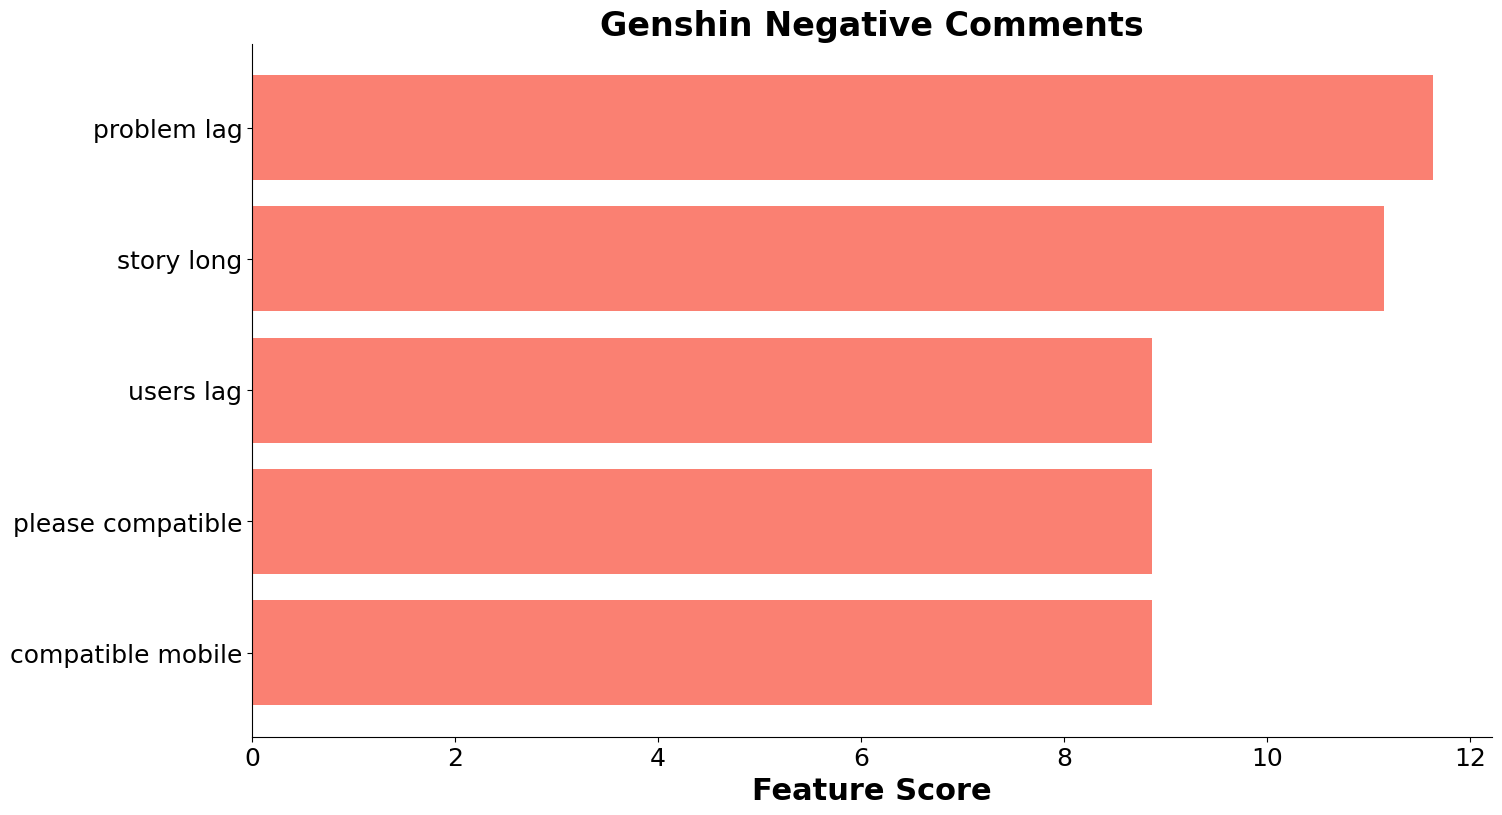

<Figure size 640x480 with 0 Axes>

In [169]:
feature_names = tfidf_n.get_feature_names_out()
scores = list(zip(feature_names, chi2score_n))
chi2_n = sorted(scores, key=lambda x: x[1])
topchi2_n = list(zip(*chi2_n[-5:]))
x_n=range(len(topchi2_n[1]))

fig, ax = plt.subplots(figsize=(16,9))
ax.barh(x_n, topchi2_n[1], align='center', alpha=1, color='salmon')

plt.title('Genshin Negative Comments', fontsize=24, weight='bold')

# x-axis
plt.xlabel("Feature Score", fontsize=22, weight='bold')
plt.xticks(fontsize=18)

#y-axis
labels = topchi2_n[0]
plt.yticks(x_n, labels, fontsize=18)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

fig = plt.gcf()
plt.show()
plt.draw()

# fig.savefig('negative.jpg')

In [170]:
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(pos_sentiment['content'])
y = pos_sentiment['score']
chi2score = chi2(X_tfidf, y)[0]

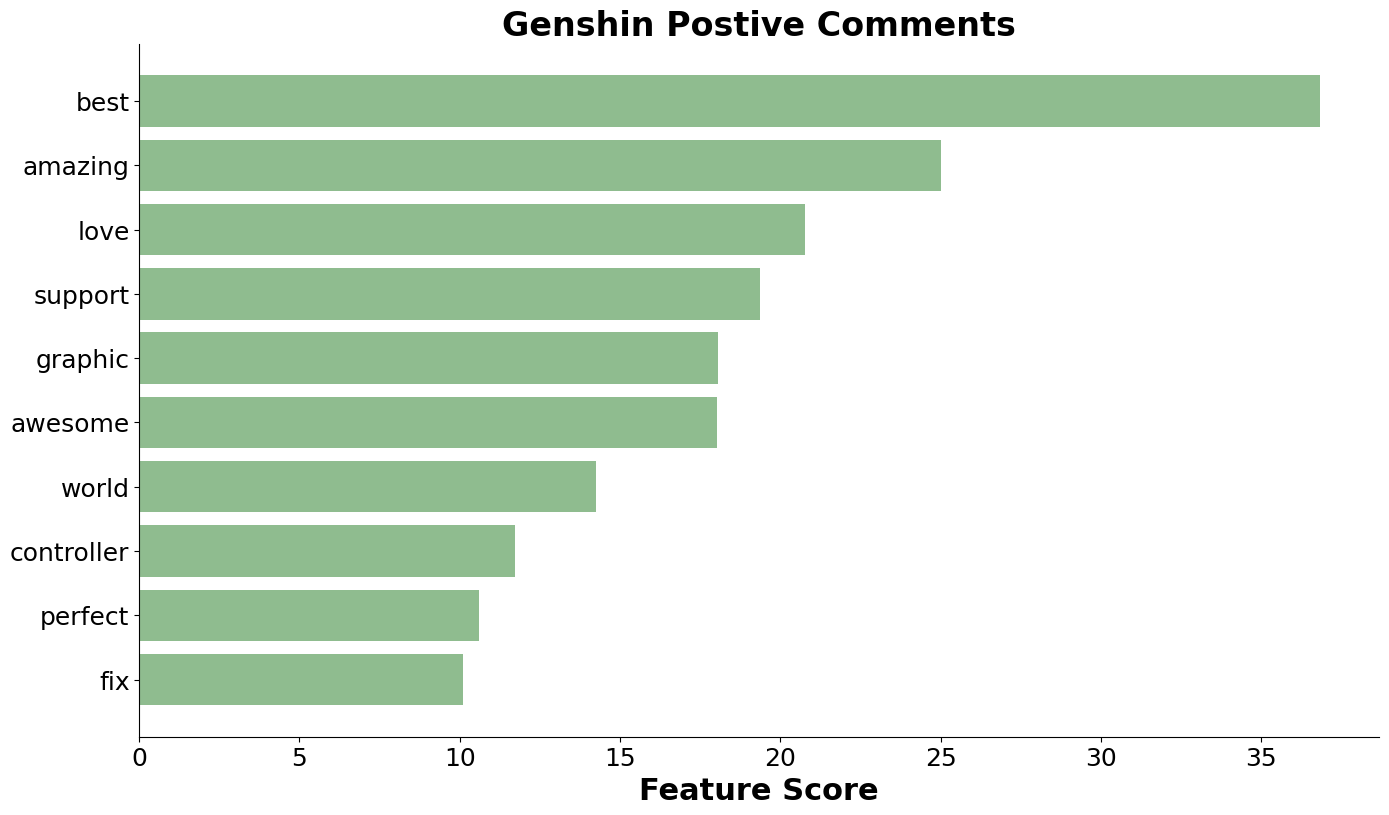

<Figure size 640x480 with 0 Axes>

In [171]:
feature_names = tfidf.get_feature_names_out()
scores = list(zip(feature_names, chi2score))
chi2 = sorted(scores, key=lambda x: x[1])
topchi2 = list(zip(*chi2[-10:]))
x = range(len(topchi2[1]))

fig, ax = plt.subplots(figsize=(16,9))
ax.barh(x,topchi2[1], alpha=1, color='darkseagreen')

plt.title('Genshin Postive Comments', fontsize=24, weight='bold')

# x-axis
plt.xlabel("Feature Score", fontsize=22, weight='bold')
plt.xticks(fontsize=18)

#y-axis
labels = topchi2[0]
plt.yticks(x, labels, fontsize=18)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

fig = plt.gcf()
plt.show()
plt.draw()

# fig.savefig('positive.jpg')